In [1]:
import pandas as pd
import scanpy as sc
from sklearn.metrics import mean_squared_error
from scipy.sparse import issparse
from matplotlib import pyplot as plt

%matplotlib inline

import numpy as np
from tqdm import tqdm

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


For ease of comparison, each run of a denoiser at some parameters will be stored in an AnnData object, along with the MCV. A sweep may generate many such objects. Note that the MCV calculation is different than just running the denoiser. These can be done simultaneously, to save memory, but also generated one-by-one, as for scVI.

For a denoised anndata object,

* `X` contains denoised values (in count space)
* `denoiser_name`  names the denoiser
* `denoising_function` is the function itself
* `denoiser_kwargs` are keyword arguments for the denoiser
* `denoiser_model` contains a fitted model if one exists

We stash the MCV:
* `mcv` contains the mcv loss (computed from one or many iterations)

The things needed for comparing methods are:

* `de` contains DE genes for each comparison
* `obsm.cluster` contains output of clustering
* `varm.ggcorr` contains gene-gene correlation matrix

# Function Defs

In [2]:
def split_adata(adata, p=0.5):
    X = adata.raw.X
    if issparse(X):
        X = np.array(X.todense())
    if np.allclose(X, X.astype(np.int)):
        X = X.astype(np.int)
    else:
        raise TypeError("Molecular cross-validation requires integer count data.")

    X1 = np.random.binomial(X, p).astype(np.float)
    X2 = X - X1
    
    adata1 = sc.AnnData(X = X1)
    adata2 = sc.AnnData(X = X2)
    
    return adata1, adata2

In [3]:
def sweep_pca(base_adata, max_pcs = 30, p = 0.9):
    adata = base_adata.copy()
    adata1, adata2 = split_adata(adata, p)

    sc.tl.pca(adata, n_comps=max_pcs, zero_center=False, random_state = 1)
    sc.tl.pca(adata1, n_comps=max_pcs, zero_center=False, random_state = 1)

    k_range = np.concatenate([np.arange(2, 10, 1), np.arange(10, 30, 2), np.arange(30, max_pcs, 5)])
    
    denoised = []
    for i, k in enumerate(tqdm(k_range)):
        reconstruction = adata.obsm['X_pca'][:,:k].dot(adata.varm['PCs'].T[:k])
        reconstruction = np.maximum(reconstruction, 0)
        
        reconstruction1 = adata1.obsm['X_pca'][:,:k].dot(adata1.varm['PCs'].T[:k])
        mcv = mean_squared_error(reconstruction1*(1-p)/p, adata2.X)
        
        adata_denoised = sc.AnnData(X = reconstruction,
                           uns = {'denoiser': 'pca',
                                  'denoiser_param': k,
                                  'denoiser_model': None,
                                  'mcv': mcv
                                  },
                            obs = base_adata.obs)
        denoised.append(adata_denoised)
    return denoised

In [430]:
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import randomized_svd


# Helper function for the diffusion denoiser, computes the diffusion operator
# as a lazy walk over a k-nearest-neighbors graph of the data in PC space.
def compute_diff_op(
    umis: np.ndarray,
    n_components: int = 30,
    n_neighbors: int = 10,
    tr_prob: float = 0.5,
):
    n_counts = np.median(umis.sum(axis=1))

    x1_norm = np.sqrt(umis / umis.sum(axis=1, keepdims=True) * n_counts)

    U, S, V = randomized_svd(x1_norm, n_components)

    p = U.dot(np.diag(S))

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(p)

    diff_op = np.array(nbrs.kneighbors_graph(p, mode="connectivity").todense())
    diff_op += diff_op.T
    diff_op = diff_op / diff_op.sum(axis=1, keepdims=True)
    diff_op = tr_prob * diff_op + (1 - tr_prob) * np.eye(diff_op.shape[0])

    return diff_op

# Diffuse gene values using a lazy walk over a kNN graph. First,
# calculates a kNN graph in PC space and uses that to define a diffusion
# operator. Next, iteratively smoothes the input data according to the
# operator, and returns the result.
def gene_diffusion(umis: np.ndarray, time_steps: int, **diff_op_kwargs):
    # calculate the diffusion operator, e.g. a weighting over a kNN graph
    diff_op = compute_diff_op(umis, **diff_op_kwargs)
    diffused_umis = umis.copy().astype(np.float)

    # perform diffusion over the knn graph
    for t in range(time_steps):
        diffused_umis = diff_op.dot(diffused_umis)

    return diffused_umis

from scipy.special import loggamma

def poisson_nll_loss(y_pred: np.ndarray, y_true: np.ndarray, per_gene=False) -> float:
    '''likelihood is e^-y y^k/k! with log   -y + k log y - log(k!)'''
    assert(np.all(y_true >= 0))
    if per_gene:
        lik = (y_pred - y_true * np.log(y_pred + 1e-6) + 
            loggamma(y_true + 1)).mean(axis = 0)
    else:
        lik = (y_pred - y_true * np.log(y_pred + 1e-6) + 
            loggamma(y_true + 1)).mean()
    return lik

def sweep_diffusion(base_adata, max_t = 10, p = 0.9):
    adata = base_adata.copy()
    adata1, adata2 = split_adata(adata, p)

    diff_op = compute_diff_op(adata.X)
    diff_op1 = compute_diff_op(adata1.X)
    
    diffused_umis = adata.X.copy().astype(np.float)
    diffused_umis1 = adata1.X.copy().astype(np.float)

    t_range = np.arange(max_t)
    
    denoised = []
    for i, t in enumerate(tqdm(t_range)):
        
        diffused_umis = diff_op.dot(diffused_umis)
        diffused_umis1 = diff_op1.dot(diffused_umis1)
        
        mcv = poisson_nll_loss(diffused_umis1*(1-p)/p, adata2.X)
        
        adata_denoised = sc.AnnData(X = diffused_umis,
                           uns = {'denoiser': 'diffusion',
                                  'denoiser_param': t,
                                  'denoiser_model': None,
                                  'mcv': mcv
                                  },
                            obs = base_adata.obs)
        denoised.append(adata_denoised)
    return denoised

In [452]:
def sweep_diffusion_per_gene(base_adata, max_t = 10, p = 0.9):
    adata = base_adata.copy()
    adata1, adata2 = split_adata(adata, p)

    diff_op = compute_diff_op(adata.X)
    diff_op1 = compute_diff_op(adata1.X)
    
    diffused_umis = adata.X.copy().astype(np.float)
    diffused_umis1 = adata1.X.copy().astype(np.float)

    best_diffused_umis = diffused_umis.copy()
    best_diffused_umis1 = diffused_umis1.copy()
    
    t_range = np.arange(max_t)
    
    mcv_losses = np.zeros((max_t, diffused_umis.shape[1]))

    for i, t in enumerate(tqdm(t_range)):       
        # Compute mcv for each gene for current diffusion
        mcv_losses[i] = poisson_nll_loss(diffused_umis1*(1-p)/p, adata2.X, per_gene=True)
        
        # Where is this best yet? Update those values
        new_best_idx = (np.min(mcv_losses[:(i+1)], axis=0) == mcv_losses[i])
        best_diffused_umis[:, new_best_idx] = diffused_umis[:, new_best_idx]
        best_diffused_umis1[:, new_best_idx] = diffused_umis1[:, new_best_idx]
        
        # Take a step
        diffused_umis = diff_op.dot(diffused_umis)
        diffused_umis1 = diff_op1.dot(diffused_umis1)
 
    mcv = poisson_nll_loss(best_diffused_umis1*(1-p)/p, adata2.X)
    print(mcv, mcv_losses.min(axis = 0).mean())
    
    adata_denoised = sc.AnnData(X = best_diffused_umis,
                       uns = {'denoiser': 'diffusion per gene',
                              'denoiser_model': None,
                              'mcv': mcv,
                              'best_t': np.argmin(mcv_losses, axis=0)
                              },
                        obs = base_adata.obs)
    denoised = [adata_denoised]
    return denoised

In [5]:
# def sweep_pca_sqrt(base_adata, max_pcs = 30, p = 0.9, n_iter = 1):
#     adata = base_adata.copy()
#     adata1, adata2 = split_adata(adata, p)

#     X = adata.X
#     X1 = adata.X1
#     sc.tl.pca(adata, n_comps=max_pcs, zero_center=False, random_state = 1)
#     sc.tl.pca(adata1, n_comps=max_pcs, zero_center=False, random_state = 1)

#     k_range = np.concatenate([np.arange(2, 10, 1), np.arange(10, 30, 2), np.arange(30, max_pcs, 5)])
    
#     denoised = []
#     for i, k in enumerate(tqdm(k_range)):
#         reconstruction = adata.obsm['X_pca'][:,:k].dot(adata.varm['PCs'].T[:k])
        
#         reconstruction1 = adata1.obsm['X_pca'][:,:k].dot(adata1.varm['PCs'].T[:k])
#         mcv = mean_squared_error(reconstruction1*(1-p)/p, adata2.X)
        
#         adata_denoised = sc.AnnData(X = reconstruction,
#                            uns = {'denoiser': 'pca',
#                                   'denoiser_param': k,
#                                   'denoiser_model': None,
#                                   'mcv': mcv
#                                   })
#         denoised.append(adata_denoised)
#     return denoised

In [6]:
def compute_gt_mse(adata_denoised, adata):
    X_true = adata.obsm['X_true']
    X = adata_denoised.X
    
    X_true = X_true*(X.sum(1, keepdims = True)/X_true.sum(1, keepdims = True))
    adata_denoised.uns['gt_mse'] = mean_squared_error(X, X_true)

In [241]:
def compute_gt_poisson(adata_denoised, adata):
    X_true = adata.obsm['X_true']
    X = adata_denoised.X
    
    X_pred = X*(X_true.sum(1, keepdims = True)/X.sum(1, keepdims = True))
    adata_denoised.uns['gt_lik'] = poisson_nll_loss(X_pred, X_true)
        
    X_true = X_true*(X.sum(1, keepdims = True)/X_true.sum(1, keepdims = True))
    adata_denoised.uns['gt_poisson'] = poisson_nll_loss(X, X_true)

In [8]:
def gene_gene_corr(adata, mat_key = None, sqrt = False):
    X = adata.X
    if sqrt:
        X = np.sqrt(X)
    if mat_key:
        X = adata.obsm[mat_key]
    corr = np.corrcoef(X, rowvar=False)
    corr = np.nan_to_num(corr)
    adata.varm['ggcorr'] = corr
    
def corr_mat_dist(cor1, cor2):
    return 1 - np.trace(cor1.dot(cor2))/np.sqrt(np.trace(cor1.dot(cor1))*np.trace(cor2.dot(cor2)))
    
def gene_gene_corr_eb(adata, mat_key = None):
    """For count data, the covariances are overdispersed."""
    X = adata.X
    if mat_key:
        X = adata.obsm[mat_key]
    
    cov = np.cov(X, rowvar=False)
    means = np.mean(X, axis = 0)
    
    var_adjusted = np.diag(cov) - means
    cov_adjusted = cov - np.diag(means)
    
    # Don't adjust if it's too small
    var_adjusted = np.maximum(var_adjusted, cov_adjusted.max(axis = 0))

    cov_adjusted = cov - np.diag(np.diag(cov)) + np.diag(var_adjusted) + 1e-6
    assert np.all(np.diag(cov_adjusted) > 0)
    
    corr = cov_adjusted / (np.sqrt(var_adjusted[:,np.newaxis] * var_adjusted[np.newaxis, :]))
    
    adata.varm['ggcorr_eb'] = corr

In [260]:
def compute_cluster(adata,
                    sqrt=True,
                    n_comps=100,
                    n_neighbors=10,
                    target_n_clusters=None,
                    metric = 'euclidean'):
    X = adata.X.copy()
    if sqrt:
        sc.pp.sqrt(adata)
    
    if 'X_latent' in adata.obsm:
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep='X_latent', metric=metric)
    else:
        sc.tl.pca(adata, n_comps=n_comps, zero_center=False)
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, metric=metric)
   
    resolution = 1
    
    sc.tl.leiden(adata, resolution = resolution)
    if target_n_clusters:
        while True:
            n_clusters = len(np.unique(adata.obs['leiden']))
            if n_clusters < target_n_clusters:
                resolution = resolution * 1.1
                sc.tl.leiden(adata, resolution = resolution)
            elif n_clusters > target_n_clusters*1.5:
                resolution = resolution * 0.9
                sc.tl.leiden(adata, resolution = resolution)
            else:
                break
    sc.tl.umap(adata)
    adata.uns['n_clusters'] = len(np.unique(adata.obs['leiden']))
    
    # restore original values of X
    adata.X = X

In [10]:
from sklearn.metrics import adjusted_rand_score

def clust_to_label(clusters, labels):
    "Given a clustering and a labeling, map each cluster to its most frequent label."
    ct = pd.crosstab(clusters, labels)
    consensus_label = np.argmax(pd.crosstab(clusters, labels).values, axis = 1)
    remapper = dict(zip(ct.index, ct.columns[consensus_label]))
    new_labels = clusters.map(remapper)
    return new_labels

def induced_label_ari(clusters, labels):
    return adjusted_rand_score(clust_to_label(clusters, labels), labels)

def print_aris(adata, ref_key, keys):
    for key in ['leiden']:
        ari = adjusted_rand_score(adata.obs[key], adata.obs[ref_key])
        induced_ari = induced_label_ari(adata.obs[key], adata.obs[ref_key])
        print(f'{key}\tInduced ARI: {induced_ari:.2}\tARI: {ari:.2}\tN Clusters:{len(adata.obs[key].unique())}')

In [85]:
def compute_ari(adata_denoised, adata, key):
    adata_denoised.uns['imputed_ari'] = induced_label_ari(adata_denoised.obs['leiden'], adata.obs[key])
    adata_denoised.uns['ari'] = adjusted_rand_score(adata_denoised.obs['leiden'], adata.obs[key])

In [12]:
def extract_best(denoised):
    best_mcv = np.inf
    best_adata = None
    
    for adata in denoised:
        if best_mcv > adata.uns['mcv']:
            best_mcv = adata.uns['mcv']
            best_adata = adata
    return best_adata

In [13]:
def plot_scalar(denoised, field):
    params = []
    values = []
    
    for adata in denoised:
        params.append(adata.uns['denoiser_param'])
        values.append(adata.uns[field])
    plt.plot(params, values)

In [123]:
def eval_denoised(denoised, gt, label, target_n_clusters=None, loss = 'mse'):
    if 'ggcorr' not in gt.varm:
        gene_gene_corr(gt, mat_key = 'X_true')
    
    for adata in denoised:
        if loss == 'mse':
            compute_gt_mse(adata, gt)
        elif loss == 'poisson':
            compute_gt_poisson(adata, gt)
        elif loss == 'scvi':
            compute_gt_scvi(adata, gt)
        else:
            raise NotImplementedError()
        
        gene_gene_corr(adata)
        adata.uns['ggcorr_error'] = corr_mat_dist(adata.varm['ggcorr'], gt.varm['ggcorr'])
    
        compute_cluster(adata, target_n_clusters=target_n_clusters)
        compute_ari(adata, gt, label)

# Do it

In [60]:
symsim = sc.read('../data/symsim/symsim.h5ad')
symsim.raw = symsim

In [61]:
denoised_pca = sweep_pca(symsim, max_pcs = 20)

100%|██████████| 18/18 [00:00<00:00, 95.98it/s]


In [62]:
eval_denoised(denoised_pca, symsim, 'pop', target_n_clusters=5, loss = 'mse')

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in tru

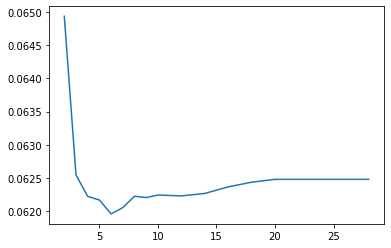

In [63]:
plot_scalar(denoised_pca, 'mcv')

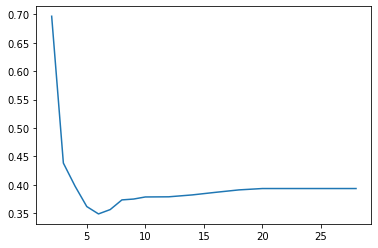

In [64]:
plot_scalar(denoised_pca, 'gt_mse')

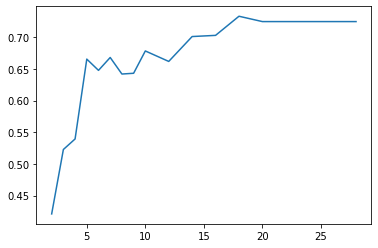

In [65]:
plot_scalar(denoised_pca, 'ari')

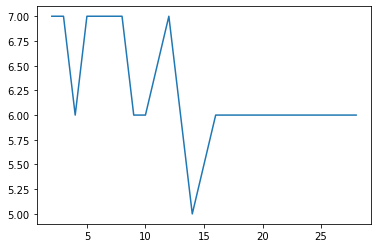

In [66]:
plot_scalar(denoised_pca, 'n_clusters')

In [67]:
best_denoised = extract_best(denoised_pca)

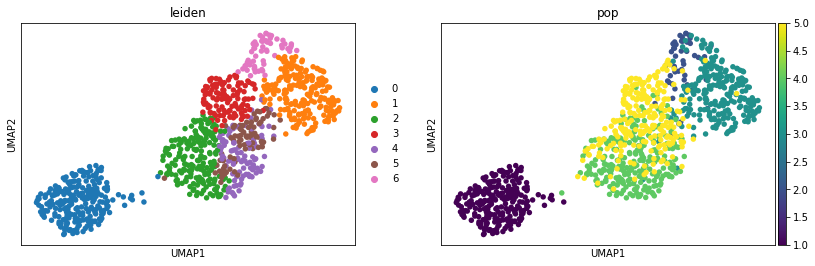

In [68]:
sc.pl.umap(best_denoised, color=['leiden', 'pop'])

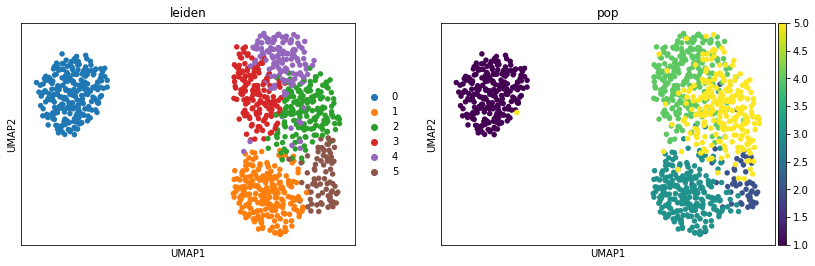

In [69]:
sc.pl.umap(denoised_pca[-1], color=['leiden', 'pop'])

# Diffusion

In [281]:
symsim = sc.read('../data/symsim/symsim.h5ad')
symsim.raw = symsim

In [282]:
denoised_diffusion = sweep_diffusion(symsim, max_t = 10)


100%|██████████| 10/10 [00:00<00:00, 13.95it/s]


In [283]:
eval_denoised(denoised_diffusion, symsim, 'pop', target_n_clusters=5, loss = 'poisson')

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in tru

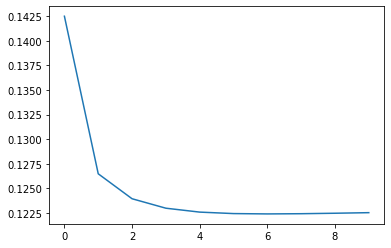

In [284]:
plot_scalar(denoised_diffusion, 'mcv')

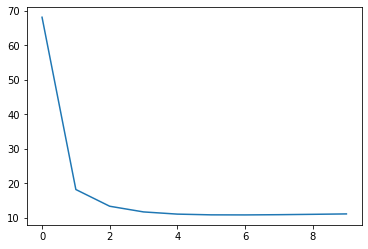

In [285]:
plot_scalar(denoised_diffusion, 'gt_lik')

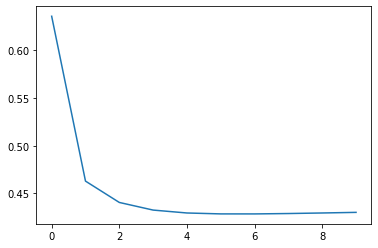

In [286]:
plot_scalar(denoised_diffusion, 'gt_poisson')

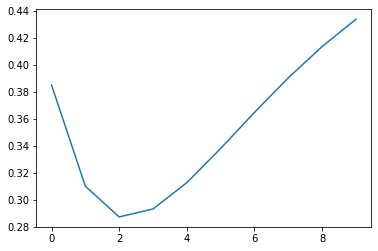

In [288]:
plot_scalar(denoised_diffusion, 'ggcorr_error')

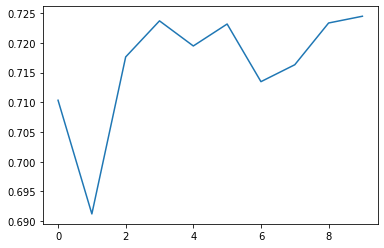

In [289]:
plot_scalar(denoised_diffusion, 'imputed_ari')

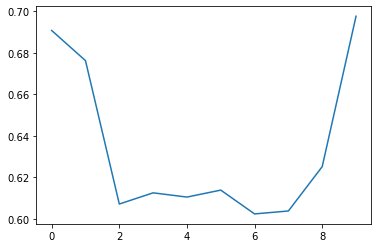

In [290]:
plot_scalar(denoised_diffusion, 'ari')

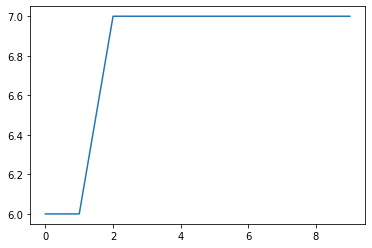

In [291]:
plot_scalar(denoised_diffusion, 'n_clusters')

In [292]:
best_denoised = extract_best(denoised_diffusion)

/Users/josh/src/scanpy/scanpy/plotting/_utils.py:255: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  if show: pl.show()


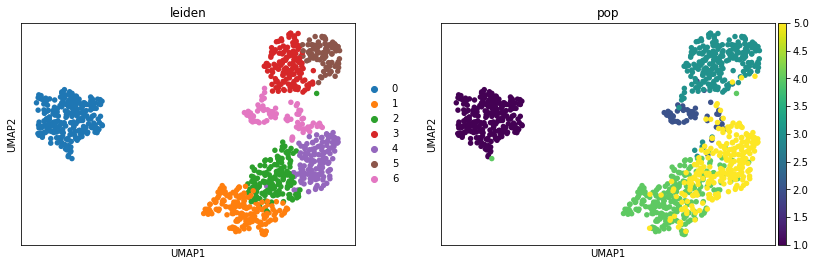

In [293]:
sc.pl.umap(best_denoised, color=['leiden', 'pop'])

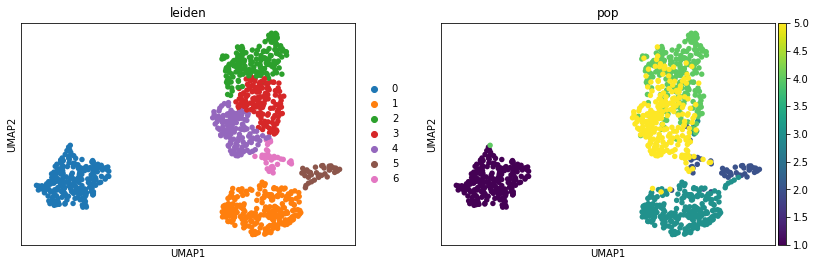

In [294]:
sc.pl.umap(denoised_diffusion[-1], color=['leiden', 'pop'])

# Per-Gene Diffusion

In [459]:
symsim = sc.read('../data/symsim/symsim.h5ad')
symsim.raw = symsim

In [460]:
denoised_pergene_diffusion = sweep_diffusion_per_gene(symsim, max_t = 20)


100%|██████████| 20/20 [00:01<00:00, 11.59it/s]

0.12060550465016011 0.12060550465016012


In [461]:
eval_denoised(denoised_pergene_diffusion, symsim, 'pop', target_n_clusters=5, loss = 'poisson')

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [462]:
for key in ['mcv', 'gt_poisson', 'gt_lik', 'ggcorr_error', 'ari', 'imputed_ari']:
    print(key, denoised_pergene_diffusion[0].uns[key])

mcv 0.12060550465016011
gt_poisson 0.4302341790963054
gt_lik 12.050422564620453
ggcorr_error 0.5023039015017066
ari 0.6576046381590309
imputed_ari 0.7093544927236671


(array([ 33.,  50.,  64.,  50.,  32.,  33.,  12.,  21.,  12., 193.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

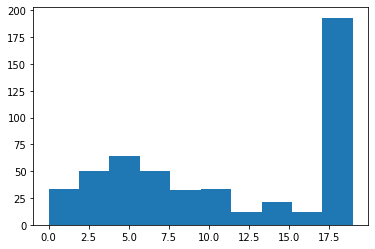

In [463]:
plt.hist(denoised_pergene_diffusion[0].uns['best_t'])

In [464]:
best_diffusion_denoised = extract_best(denoised_diffusion)

In [465]:
for key in ['mcv', 'gt_poisson', 'gt_lik', 'ggcorr_error', 'ari', 'imputed_ari']:
    print(key, best_diffusion_denoised.uns[key])

mcv 0.12241373160671863
gt_poisson 0.4285488739701508
gt_lik 10.768706729868972
ggcorr_error 0.3646239565528585
ari 0.6022943825356778
imputed_ari 0.7134801703324932


# scVI

In [242]:
from typing import Tuple

import scvi
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE
import torch
from scvi.models.log_likelihood import log_nb_positive

In [308]:
def compute_scvi_latent(
    adata: sc.AnnData,
    n_latent: int = 5,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = False,
    use_cuda: bool = False,
) -> Tuple[scvi.inference.Posterior, np.ndarray]:
    # Convert easily to scvi dataset
    scviDataset = AnnDatasetFromAnnData(adata)

    # Train a model
    vae = VAE(
        scviDataset.nb_genes,
        n_batch=scviDataset.n_batches * use_batches,
        n_latent=n_latent,
        reconstruction_loss = 'nb'
    )
    trainer = UnsupervisedTrainer(vae, scviDataset,
                                  train_size=1.0, use_cuda=use_cuda,
                                  )
    trainer.train(n_epochs=n_epochs, lr=lr)

    posterior = trainer.create_posterior(
        trainer.model, scviDataset, indices=np.arange(len(scviDataset))
    ).sequential()

    latent, _, _ = posterior.get_latent()

    return posterior, latent

In [309]:
posterior, latent = compute_scvi_latent(symsim)


training: 100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


In [313]:
from sklearn.cluster import KMeans

In [315]:
KMeans(n_clusters=5)

In [109]:
@torch.no_grad()
def get_sample_rate(posterior):
    px_scales = []
    for tensors in posterior:
        sample_batch, _, _, batch_index, labels = tensors
        px_scales += [
            np.array(
                (
                    posterior.model.get_sample_rate(
                        sample_batch, batch_index=batch_index, y=labels, n_samples=1
                    )
                ).cpu()
            )
        ]
    return np.concatenate(px_scales)

In [243]:
def scvi_likelihood(posterior, x_valid, validation_to_train_ratio = None, n_samples = 1):
    """Compute negative binomial likelihood of x_valid with respect to the posterior."""
    nll = 0
    for i in range(n_samples):
        px_r = torch.exp(posterior.model.px_r.detach().cpu())

        if validation_to_train_ratio is None:
            px_scale = posterior.get_sample_scale()
            library = x_valid.sum(1)
            px_rate = px_scale*library.reshape(-1,1)
        else:
            px_rate = get_sample_rate(posterior) * validation_to_train_ratio

        x_valid, px_rate, px_r = [torch.Tensor(t) for t in [x_valid, px_rate, px_r]]

        nll += -log_nb_positive(x_valid, px_rate, px_r).mean(dim=-1).mean().item()
    return nll/n_samples

In [244]:
def sweep_scvi(base_adata, max_latent=30, p=0.9, n_epochs=300):
    adata = base_adata.copy()
    adata1, adata2 = split_adata(adata, p)

    k_range = np.arange(5, max_latent + 5, 5)
    denoised = []
    
    for i, k in enumerate((k_range)):
        print(f"Computing n_latent = {k}")
        scvi.set_verbosity(0)
        
        posterior1, _ = compute_scvi_latent(adata1, n_latent=k, n_epochs=n_epochs)
        mcv = scvi_likelihood(posterior1, adata2.X, validation_to_train_ratio=(1-p)/p)

        posterior, latent = compute_scvi_latent(adata, n_latent=k, n_epochs=n_epochs)

        adata_denoised = sc.AnnData(X = get_sample_rate(posterior),
                           uns = {'denoiser': 'scvi',
                                  'denoiser_param': k,
                                  'scvi_posterior': posterior,
                                  'mcv': mcv
                                  },
                            obs = base_adata.obs,
                            obsm = {'X_latent': latent})
        denoised.append(adata_denoised)
    return denoised

def compute_gt_scvi(adata_denoised, adata):
    X_true = adata.obsm['X_true']
    posterior = adata_denoised.uns['scvi_posterior']
    adata_denoised.uns['gt_lik'] = scvi_likelihood(posterior, X_true)
                                        
def compute_de_scvi(adata_denoised, label):
    raise NotImplementedError()

In [297]:
symsim = sc.read('../data/symsim/symsim.h5ad')
symsim.raw = symsim

In [268]:
denoised_scvi = sweep_scvi(symsim, max_latent=15, n_epochs=400)

Computing n_latent = 5

training:  32%|███▎      | 130/400 [00:23<00:48,  5.56it/s]


training:  65%|██████▌   | 260/400 [00:46<00:23,  5.93it/s]


training:  98%|█████████▊| 390/400 [01:08<00:01,  5.79it/s]


training: 100%|██████████| 400/400 [01:10<00:00,  5.69it/s]

training:  30%|███       | 120/400 [00:20<00:48,  5.80it/s]


training:  62%|██████▎   | 250/400 [00:43<00:26,  5.77it/s]


training:  95%|█████████▌| 380/400 [01:05<00:03,  5.63it/s]


training: 100%|██████████| 400/400 [01:09<00:00,  5.80it/s]
Computing n_latent = 10

training:  28%|██▊       | 110/400 [00:19<00:54,  5.32it/s]


training:  60%|██████    | 240/400 [00:42<00:27,  5.74it/s]


training:  92%|█████████▎| 370/400 [01:05<00:05,  5.59it/s]


training: 100%|██████████| 400/400 [01:10<00:00,  5.66it/s]

training:  25%|██▌       | 100/400 [00:17<00:57,  5.18it/s]


training:  57%|█████▊    | 230/400 [00:41<00:30,  5.52it/s]


training:  90%|█████████ | 360/400 [01:05<00:07,  5.48it/s]


training: 100%|██████████| 400/400 [01:12<00:00,  5.55it/s]
Computing n_latent = 15

training:  22%|██▎       | 90/400 [00:16<00:55,  5.63it/s]


training:  55%|█████▌    | 220/400 [00:39<00:36,  4.91it/s]


training:  88%|████████▊ | 350/400 [01:02<00:08,  5.76it/s]


training: 100%|██████████| 400/400 [01:10<00:00,  5.65it/s]

training:  20%|██        | 80/400 [00:13<00:55,  5.76it/s]


training:  52%|█████▎    | 210/400 [00:36<00:32,  5.79it/s]


training:  85%|████████▌ | 340/400 [00:58<00:10,  5.72it/s]


training: 100%|██████████| 400/400 [01:09<00:00,  5.80it/s]


In [269]:
eval_denoised(denoised_scvi, symsim, 'pop',
              target_n_clusters=5,
              loss = 'scvi')

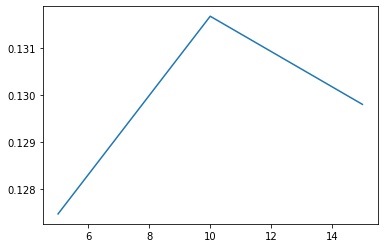

In [272]:
plot_scalar(denoised_scvi, 'mcv')

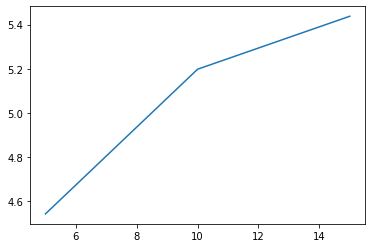

In [277]:
plot_scalar(denoised_scvi, 'gt_lik')

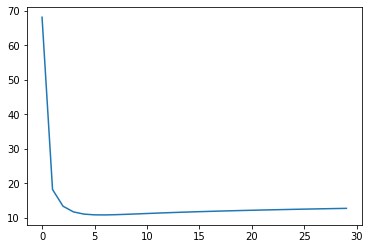

In [276]:
plot_scalar(denoised_diffusion, 'gt_lik')

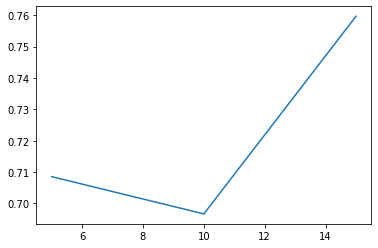

In [253]:
plot_scalar(denoised_scvi, 'ggcorr_error')

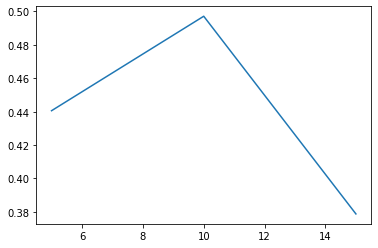

In [278]:
plot_scalar(denoised_scvi, 'ari')

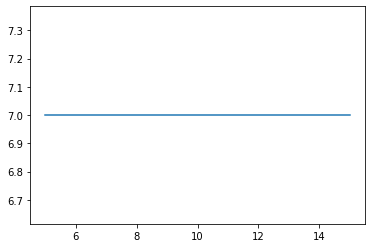

In [255]:
plot_scalar(denoised_scvi, 'n_clusters')

In [256]:
best_denoised = extract_best(denoised_scvi)

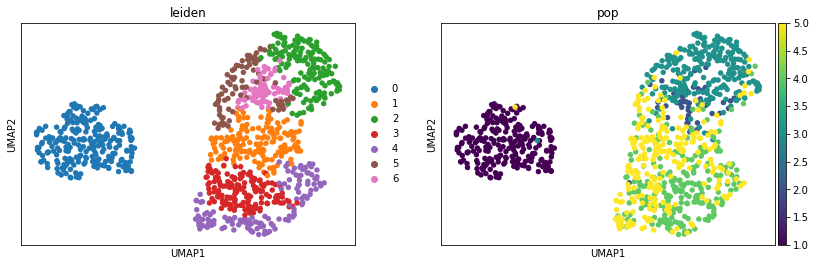

In [267]:
sc.pl.umap(best_denoised, color=['leiden', 'pop'])

/Users/josh/src/scanpy/scanpy/plotting/_utils.py:255: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  if show: pl.show()


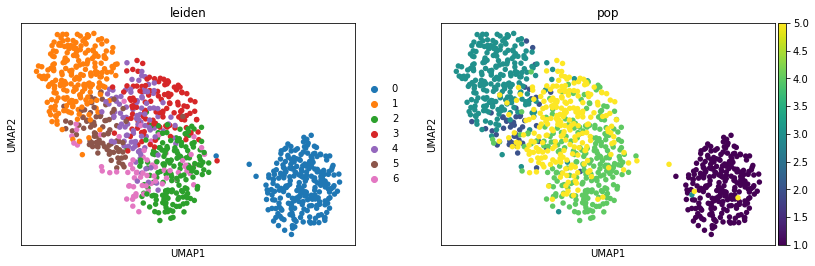

In [265]:
sc.pl.umap(denoised_scvi[-1], color=['leiden', 'pop'])

In [264]:
for adata in denoised_scvi:
    compute_cluster(adata, target_n_clusters=5, metric='cosine')
    compute_ari(adata, symsim, 'pop')

# Clustering ground-truth data

ARI from ground-truth

In [40]:
symsim_gt = symsim.copy()
symsim_gt.X = symsim.obsm['X_true']
compute_cluster(symsim_gt)
compute_ari(symsim_gt, symsim, 'pop')
print(symsim_gt.uns['ari'])

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


0.8345740951723358


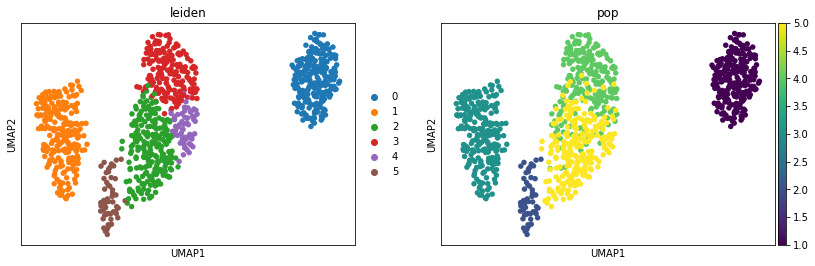

In [41]:
sc.pl.umap(symsim_gt, color=['leiden', 'pop'])

# Visualizing gene correlations

In [42]:
import seaborn as sns

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


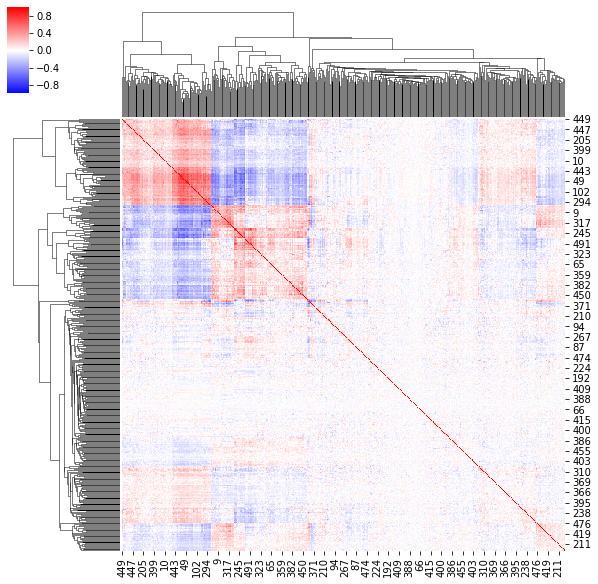

In [43]:
sns.clustermap(symsim.varm['ggcorr'], cmap = 'bwr', vmin = -1, vmax = 1)

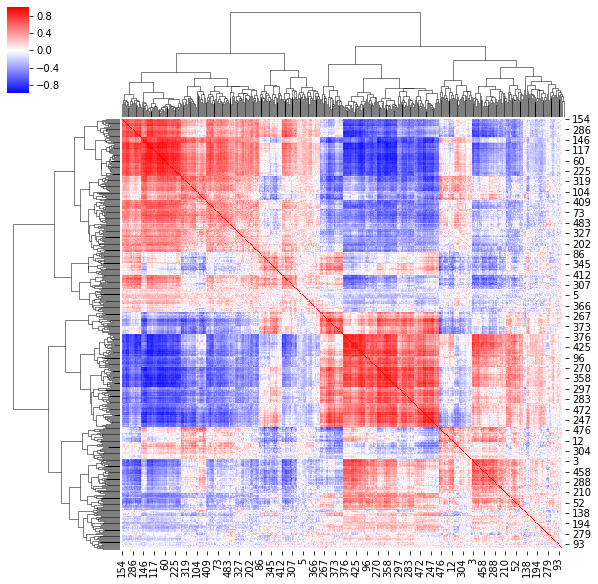

In [44]:
sns.clustermap(best_denoised.varm['ggcorr'], cmap = 'bwr', vmin = -1, vmax = 1)

# Per-Gene Diffusion

In [328]:
# Negative log likelihood
def poisson_log_lik(lam, k, per_gene = False):
    if per_gene:
        return (lam - k*np.log(lam + 1e-6)).mean(axis = 0)
    else:
        return (lam - k*np.log(lam + 1e-6)).mean()

In [322]:
%load_ext autoreload
%autoreload 2

In [353]:
symsim_gt = symsim.copy()
symsim_gt.X = symsim.obsm['X_true']
symsim_gt.raw = symsim_gt

In [364]:
adata1, adata2 = split_adata(symsim_gt, p = 0.5)
x1, x2 = adata1.X, adata2.X

In [393]:
X = symsim.X.astype(np.int)

p = 0.9

x1 = np.random.binomial(X, p)
x2 = X - x1

max_t = 20

diff_op = compute_diff_op(x1)

x1_norm = x1.astype(np.float)
x2_norm = x2.astype(np.float)

denoised = x1_norm
target = x2_norm
best_denoised = x1_norm

ss_losses = np.zeros((max_t, x1.shape[1]))

t_range = np.arange(max_t)

for t in t_range:
    ss_losses[t] = poisson_log_lik(denoised*(1-p)/p, target, per_gene=True)
    new_best_idx = (np.min(ss_losses[:(t+1)], axis=0) == ss_losses[t])
    best_denoised[:, new_best_idx] = denoised[:, new_best_idx]

    denoised = diff_op.dot(denoised)
best_t = np.argmin(ss_losses, axis=0)

(array([ 21.,  47.,  71.,  61.,  37.,  22.,  16.,  16.,  12., 197.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

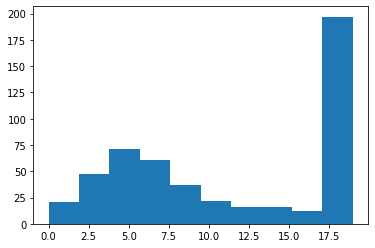

In [394]:
plt.hist(best_t)

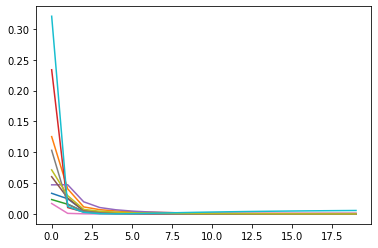

In [403]:
plt.plot((ss_losses - ss_losses.min(axis = 0))[:,::50])

In [390]:
X = symsim.X.astype(np.int)

p = 0.9

x1 = np.random.binomial(X, p)
x2 = X - x1

max_t = 20

diff_op = compute_diff_op(x1)

x1_norm = x1.astype(np.float)
x2_norm = x2.astype(np.float)

denoised = x1_norm
target = x2_norm
best_denoised = x1_norm

ss_losses = np.zeros(max_t)

t_range = np.arange(max_t)

for t in t_range:
    ss_losses[t] = poisson_log_lik(denoised*(1-p)/p, target, per_gene=False)
   
    denoised = diff_op.dot(denoised)
np.argmin(ss_losses)

7